# EXPLORATION_16. 다음에 볼 영화 예측하기

## 프로젝트 - Movielens 영화 SBR   
이번 프로젝트는 Movielens 1M Dataset 을 기반으로, Session based Recommendation 시스템을 제작해보자!!!!

In [1]:
## 필요한 라이브러리 import
## 그리고 그 라이브러리 버전 확인하기!

import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
## 필요한 라이브러리 import

import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

<준비물>    

1. 데이터 확인    
- $ ls -l ~/data   

2. 프로젝트 폴더 생성   
- $ mkdir -p ~/aiffel/yoochoose   

3. 프로젝트 폴더로 데이터 폴더 링크 연결   
- $ ln -s ~/data/* ~/aiffel/yoochoose/data

In [3]:
## 데이터를 불러오자~~~~~

data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  ## data를 id와 시간 순서로 정렬해준다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리   
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [4]:
## Uniqe 한 유저, 영화, 시간의 수를 확인해보기!

print('Unique 한 유저의 수 :',data['UserId'].nunique())
print('Unique 한 영화의 수 :',data['ItemId'].nunique()) 
print('Unique 한 시간의 수 :',data['Time'].nunique())

Unique 한 유저의 수 : 6040
Unique 한 영화의 수 : 3706
Unique 한 시간의 수 : 458455


In [5]:
## 그냥 데이터가 어떤 정보를 가지고 있는지 확인해보기

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


### 1) Session ID 정의

In [6]:
## UserId와 Time을 기준으로 새로운 데이터프레임 생성

df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [7]:
## SessionId 컬럼 추가

data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 2) Session Length    
각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보자!!!

In [8]:
## session_length 란 SessionId를 공유하는 데이터 row의 개수를 의미한다.

session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

session_lenght 란 해당 세션의 사용자가 그 세션 동안 몇 번의 액션을 취해쓴지 ( 몇 개의 상품정보를 클릭했는지) 의 의미가 된다.

In [9]:
## 중간값

session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [10]:
## 최솟값, 최댓값

session_length.min(), session_length.max()

(1, 30)

In [11]:
## 99.9 백분위수 (99.9%)

session_length.quantile(0.999)

10.0

In [12]:
length_count = session_length.groupby(session_length).size()
length_count

1     226181
2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
11       106
12        83
13        85
14        48
15        38
16        29
17        16
18        13
19         9
20        14
21         6
22         7
23         5
25         2
26         2
27         2
28         2
30         1
dtype: int64

In [13]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [14]:
## 분포 누적합

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

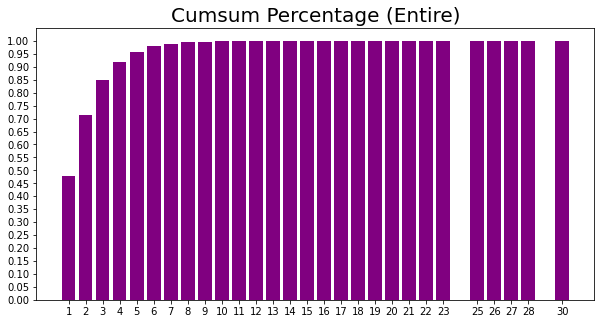

In [15]:
## 전체 분포 누적합 시각화

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum, color='purple')    ## 보라색으로~~~~~~
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage (Entire)', size=20)
plt.show()

### 3) Session Time (세션단위 정의 과정 : 시간 분석)

In [16]:
## 우리가 다루려는 데이터의 시간 관련 정보를 확인해보자!
## Time 데이터의 초단위의 최솟값, 최댓값

oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [17]:
type(latest)

numpy.int64

latest의 type 을 확인해보니까 latest 는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다.

In [18]:
years_ago = latest - (86400*365*3)   ## 최종 날짜로부터 3년 이전 날짜를 구한다.  
data = data[data['Time'] > years_ago]   ## 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


### 4) Data Cleansing

In [19]:
## short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있다.
## 이를 위해 반복문을 통해 지속적으로 제거 한다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [20]:
## 평점 3점 이상만 살린다.

data = data[data['Rating'] >= 3]
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,978300019,3186,4
1,1,1,978300055,1270,5
2,1,1,978300055,1721,4
3,1,1,978300055,1022,5
4,2,1,978300103,2340,3
...,...,...,...,...,...
1000204,471159,6040,997454429,2917,4
1000205,471160,6040,997454464,1921,4
1000206,471160,6040,997454464,1784,3
1000207,471161,6040,997454486,161,3


### 5) Train / Valid / Test split   
훈련 데이터, 테스트 데이터, 검증 데이터 나누기

모델 평가를 위해서 Valid Set 과 Test Set을 만들어보자      
근데 Test Set 을 제공해주고 있음

In [46]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [47]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [48]:
## data에 대한 정보를 살펴보자!

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [49]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 819375
	 Sessions: 6037
	 Items: 3618
	 First Time : 956703932
	 Last Time : 1015301653

* valid Set Stats Info
	 Events: 9795
	 Sessions: 390
	 Items: 2372
	 First Time : 1015302260
	 Last Time : 1030854059

* test Set Stats Info
	 Events: 7298
	 Sessions: 333
	 Items: 2064
	 First Time : 1030909299
	 Last Time : 1046454590



In [50]:
## train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  ## id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

데이터 준비는 끝!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [51]:
## 데이터를 저장하자!

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성   
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## Data Pipeline    
이전 데이터 전처리에서 개념을 정리해 본 Session-Parallel Mini-Batch 를 구현해보자

### 1) SessionDataset    
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

In [52]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  ## indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [53]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [54]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 819373, 819374, 819375], dtype=int32)

In [55]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 411074, 411075, 411076])

### 2) SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch 를 만드는 클래스를 만든다.   
__iter__ 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield 한다.   
mask 는 후에 RNN Cell State 를 초기화하는데 사용할 것이다. 

In [56]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):   ## 모델 input, label, session이 끝나는 곳의 위치를 생성하는 함수
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  ## initialize 메소드에서 확인
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  ## Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    ## 첫 배치에 사용할 세션 Index를 가져온다.
        last_session = self.batch_size - 1    ## 마지막으로 다루고 있는 세션 Index를 저장해둔다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       ## data 상에서 session이 시작된 위치를 가져온다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  ## session이 끝난 위치 바로 다음 위치를 가져온다.
        mask = np.array([])   ## session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것이다.
        finished = False         ## data를 전부 돌았는지 기록하기 위한 변수이다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        ## 다음 배치 데이터를 생성하기 위해 상태를 update한다.
        
        start += min_len   ## __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해준다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        ## end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻. mask에 기록해준다.

        for i, idx in enumerate(mask, start=1):  ## mask에 추가된 세션 개수만큼 새로운 세션을 돌것이다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  ## 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것이다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     ## 종료된 세션 대신 새로운 세션의 시작점을 기록한다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  ## 마지막 세션의 위치를 기록해둔다.
        return start, end, mask, last_session, finished

In [57]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [58]:
iter_ex = iter(tr_data_loader)

In [59]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## Step 3. 모델 구성  
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

### 1) Evaluation Metric    
모델 성능 평가를 위한 지표를 보자!         
모델 성능에 대한 지표로 precision 이나 recall 이 있다.

In [60]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 2) Model Architecture    
모델 구조를 구현할 것이다. 모델 구조가 간단한 편이기 때문에 Functional 하게 모델을 만들겠다.    

- 여기서 Functional 은 범함수라는 건디 이게 맞는지는 잘 모르겠다.   
- 범함수는 함수들의 집합을 정의역으로 갖는 함수이다.

In [64]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [65]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [66]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=3, k=50)

In [67]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    550500    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습  
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

#### 시도 1.   
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=3, k=50) 기본으로 설정하고 한 번 결과를 봤다! 

### 3) Model Training    
이제는 준비한 데이터셋으로 모델을 통해서 학습을 진행할 것이다.

In [68]:
## train 셋으로 학습하면서 valid 셋으로 검증한다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  ## 종료된 session은 hidden_state를 초기화한다. 아래 메서드에서 확인!.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  ## valid set에 대해 검증한다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  ## model에서 gru layer를 가져온다!
    hidden_states = gru_layer.states[0].numpy()  ## gru_layer의 parameter를 가져온다!
    for elt in mask:  ## mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  ## parameter를 초기화 한다.
    gru_layer.reset_states(states=hidden_states)
    
    
def get_metrics(data, model, args, k: int):  ## valid셋과 test셋을 평가하는 코드이다.
                                             ## train과 거의 같지만 mrr, recall을 구하는 라인이 있다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  ## softmax 값이 큰 순서대로 sorting 한다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [69]:
## 학습 시간이 다소 오래 소요 
train_model(model, args)

Evaluation:  90%|█████████ | 9/10 [00:26<00:02,  2.96s/it]


	 - Recall@50 epoch 1: 0.085503
	 - MRR@50    epoch 1: 0.008082



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]


	 - Recall@50 epoch 2: 0.095920
	 - MRR@50    epoch 2: 0.009927



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

	 - Recall@50 epoch 3: 0.102865
	 - MRR@50    epoch 3: 0.011832



## Step 5. 모델 테스트  
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### 4) Inference    
지금까지 작성한 모델이 테스트셋에 대해서 어느 정도 성능을 내는지 검증해보자!

In [70]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  86%|████████▌ | 6/7 [00:07<00:01,  1.30s/it]

	 - Recall@50: 0.060547
	 - MRR@50: 0.012745



#### 시도 2.   
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50)  에폭을 3에서 10으로 증가시켰다.

In [71]:
args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50)
train_model(model, args)

Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]


	 - Recall@50 epoch 1: 0.103299
	 - MRR@50    epoch 1: 0.012155



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]


	 - Recall@50 epoch 2: 0.102865
	 - MRR@50    epoch 2: 0.012591



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]


	 - Recall@50 epoch 3: 0.105469
	 - MRR@50    epoch 3: 0.012673



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]


	 - Recall@50 epoch 4: 0.105469
	 - MRR@50    epoch 4: 0.012701



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]


	 - Recall@50 epoch 5: 0.105469
	 - MRR@50    epoch 5: 0.012703



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]


	 - Recall@50 epoch 6: 0.105469
	 - MRR@50    epoch 6: 0.012715



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]


	 - Recall@50 epoch 7: 0.105469
	 - MRR@50    epoch 7: 0.012728



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]


	 - Recall@50 epoch 8: 0.105469
	 - MRR@50    epoch 8: 0.012743



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]


	 - Recall@50 epoch 9: 0.105469
	 - MRR@50    epoch 9: 0.012743



Evaluation:  90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

	 - Recall@50 epoch 10: 0.106337
	 - MRR@50    epoch 10: 0.012757



In [72]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  86%|████████▌ | 6/7 [00:08<00:01,  1.34s/it]

	 - Recall@50: 0.053385
	 - MRR@50: 0.012186



#### 시도 3.   
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50) 기본으로 설정하고 한 번 결과를 봤다! batch_size 를 줄이고 에폭을 3에서 10으로 증가시켰다.

In [75]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50)

In [76]:
model_1 = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [78]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50)
train_model(model_1, args)

Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 1: 0.096094
	 - MRR@50    epoch 1: 0.009701



Evaluation:  95%|█████████▌| 20/21 [00:28<00:01,  1.44s/it]


	 - Recall@50 epoch 2: 0.099219
	 - MRR@50    epoch 2: 0.011390



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 3: 0.100781
	 - MRR@50    epoch 3: 0.011819



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.47s/it]


	 - Recall@50 epoch 4: 0.101172
	 - MRR@50    epoch 4: 0.011884



Evaluation:  95%|█████████▌| 20/21 [00:28<00:01,  1.45s/it]


	 - Recall@50 epoch 5: 0.102344
	 - MRR@50    epoch 5: 0.012012



Evaluation:  95%|█████████▌| 20/21 [00:31<00:01,  1.57s/it]


	 - Recall@50 epoch 6: 0.103906
	 - MRR@50    epoch 6: 0.012084



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.49s/it]


	 - Recall@50 epoch 7: 0.102344
	 - MRR@50    epoch 7: 0.012051



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 8: 0.102344
	 - MRR@50    epoch 8: 0.012049



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.45s/it]


	 - Recall@50 epoch 9: 0.102344
	 - MRR@50    epoch 9: 0.012050



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.45s/it]

	 - Recall@50 epoch 10: 0.102344
	 - MRR@50    epoch 10: 0.012048



In [80]:
def test_model(model_1, args, test):
    test_recall, test_mrr = get_metrics(test, model_1, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model_1, args, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.44it/s]

	 - Recall@50: 0.053571
	 - MRR@50: 0.012630



#### 시도 4.   
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=50) 이번에는 drop_rate 랑 lr 값을 변경 시켜봤다.

In [81]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=50)

In [82]:
model_2 = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [83]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=50)
train_model(model_2, args)

Evaluation:  95%|█████████▌| 20/21 [00:27<00:01,  1.39s/it]


	 - Recall@50 epoch 1: 0.197266
	 - MRR@50    epoch 1: 0.037662



Evaluation:  95%|█████████▌| 20/21 [00:25<00:01,  1.27s/it]


	 - Recall@50 epoch 2: 0.296875
	 - MRR@50    epoch 2: 0.068648



Evaluation:  95%|█████████▌| 20/21 [00:24<00:01,  1.23s/it]


	 - Recall@50 epoch 3: 0.336328
	 - MRR@50    epoch 3: 0.079545



Evaluation:  95%|█████████▌| 20/21 [00:24<00:01,  1.20s/it]


	 - Recall@50 epoch 4: 0.353906
	 - MRR@50    epoch 4: 0.083676



Evaluation:  95%|█████████▌| 20/21 [00:23<00:01,  1.20s/it]


	 - Recall@50 epoch 5: 0.358984
	 - MRR@50    epoch 5: 0.086098



Evaluation:  95%|█████████▌| 20/21 [00:24<00:01,  1.21s/it]


	 - Recall@50 epoch 6: 0.362109
	 - MRR@50    epoch 6: 0.088399



Evaluation:  95%|█████████▌| 20/21 [00:24<00:01,  1.22s/it]


	 - Recall@50 epoch 7: 0.363281
	 - MRR@50    epoch 7: 0.088157



Evaluation:  95%|█████████▌| 20/21 [00:23<00:01,  1.19s/it]


	 - Recall@50 epoch 8: 0.362500
	 - MRR@50    epoch 8: 0.089199



Evaluation:  95%|█████████▌| 20/21 [00:23<00:01,  1.20s/it]


	 - Recall@50 epoch 9: 0.362109
	 - MRR@50    epoch 9: 0.089911



Evaluation:  95%|█████████▌| 20/21 [00:24<00:01,  1.22s/it]

	 - Recall@50 epoch 10: 0.362500
	 - MRR@50    epoch 10: 0.089220



In [84]:
def test_model(model_2, args, test):
    test_recall, test_mrr = get_metrics(test, model_2, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model_2, args, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.53it/s]

	 - Recall@50: 0.235491
	 - MRR@50: 0.079946



#### 시도 5.   
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=30, k=50)  이번에는 epochs를 30으로 확 늘려보았다.

In [85]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=30, k=50)

In [86]:
model_3 = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 3618)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    550500    
_________________________________________________________________
dropout_4 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_4 (Dense)              (128, 3618)               184518    
Total params: 735,018
Trainable params: 735,018
Non-trainable params: 0
_________________________________________________________________


In [87]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=30, k=50)
train_model(model_3, args)

Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.47s/it]


	 - Recall@50 epoch 1: 0.094531
	 - MRR@50    epoch 1: 0.010327



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.47s/it]


	 - Recall@50 epoch 2: 0.099609
	 - MRR@50    epoch 2: 0.011304



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.45s/it]


	 - Recall@50 epoch 3: 0.098437
	 - MRR@50    epoch 3: 0.011903



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 4: 0.100391
	 - MRR@50    epoch 4: 0.011961



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.47s/it]


	 - Recall@50 epoch 5: 0.101953
	 - MRR@50    epoch 5: 0.011998



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.49s/it]


	 - Recall@50 epoch 6: 0.102344
	 - MRR@50    epoch 6: 0.012043



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.47s/it]


	 - Recall@50 epoch 7: 0.102344
	 - MRR@50    epoch 7: 0.012057



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.50s/it]


	 - Recall@50 epoch 8: 0.101953
	 - MRR@50    epoch 8: 0.012044



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.50s/it]


	 - Recall@50 epoch 9: 0.101953
	 - MRR@50    epoch 9: 0.012044



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 10: 0.101953
	 - MRR@50    epoch 10: 0.012047



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 11: 0.101953
	 - MRR@50    epoch 11: 0.012047



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 12: 0.101953
	 - MRR@50    epoch 12: 0.012047



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 13: 0.101953
	 - MRR@50    epoch 13: 0.012045



Evaluation:  95%|█████████▌| 20/21 [00:28<00:01,  1.44s/it]


	 - Recall@50 epoch 14: 0.103516
	 - MRR@50    epoch 14: 0.012078



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 15: 0.101953
	 - MRR@50    epoch 15: 0.012047



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 16: 0.103516
	 - MRR@50    epoch 16: 0.012078



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.45s/it]


	 - Recall@50 epoch 17: 0.101953
	 - MRR@50    epoch 17: 0.012047



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.49s/it]


	 - Recall@50 epoch 18: 0.103516
	 - MRR@50    epoch 18: 0.012076



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 19: 0.103516
	 - MRR@50    epoch 19: 0.012086



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 20: 0.103516
	 - MRR@50    epoch 20: 0.012076



Evaluation:  95%|█████████▌| 20/21 [00:30<00:01,  1.52s/it]


	 - Recall@50 epoch 21: 0.103516
	 - MRR@50    epoch 21: 0.012086



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 22: 0.103516
	 - MRR@50    epoch 22: 0.012086



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 23: 0.103516
	 - MRR@50    epoch 23: 0.012107



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.49s/it]


	 - Recall@50 epoch 24: 0.103516
	 - MRR@50    epoch 24: 0.012086



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.49s/it]


	 - Recall@50 epoch 25: 0.103516
	 - MRR@50    epoch 25: 0.012086



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.46s/it]


	 - Recall@50 epoch 26: 0.101953
	 - MRR@50    epoch 26: 0.012055



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 27: 0.101953
	 - MRR@50    epoch 27: 0.012076



Evaluation:  95%|█████████▌| 20/21 [00:30<00:01,  1.52s/it]


	 - Recall@50 epoch 28: 0.103516
	 - MRR@50    epoch 28: 0.012107



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]


	 - Recall@50 epoch 29: 0.103516
	 - MRR@50    epoch 29: 0.012107



Evaluation:  95%|█████████▌| 20/21 [00:29<00:01,  1.48s/it]

	 - Recall@50 epoch 30: 0.101953
	 - MRR@50    epoch 30: 0.012076



In [88]:
def test_model(model_3, args, test):
    test_recall, test_mrr = get_metrics(test, model_3, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model_3, args, test)

Evaluation:  93%|█████████▎| 14/15 [00:09<00:00,  1.42it/s]

	 - Recall@50: 0.053571
	 - MRR@50: 0.012672



# 회고~

## < 어려웠던 점>   
더 여러가지 시도를 해보고 싶었는데 잘 변경을 하지 못해서 아쉽다... 다양한 결과를 보고 분석을 해보고 싶었지만 그게 잘 안되는거 같아서 속상하다. 아직까지 코드나 결과값을 분석을 하는거에 익숙하지 않아서 쉽지가 않은 것 같다...휴우 열심히 해야하는데 할 게 많아서 시간을 더 많이 쏟지 않았던 것 같다...(핑계)

## < 알아낸 점> & < 아직까지 모호한 점>      
추천시스템에서 여러가지를 배워봤지만 또 SBR 은 처음해보는 것 같다. SBR 은 Session based Recommendation의 줄인말이라는 것도 알게되었다. 

## <시도한 것들>    

- 시도 1.   
    args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=3, k=50) 기본으로 설정하고 한 번 결과를 봤다!        
        
- 시도 2.   
    args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50)  에폭을 3에서 10으로 증가시켰다.       
    
-  시도 3.   
    args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=10, k=50) 기본으로 설정하고 한 번 결과를 봤다! batch_size 를 줄이고 에폭을 3에서 10으로 증가시켰다.      
    
- 시도 4.   
    args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=50) 이번에는 drop_rate 랑 lr 값을 변경 시켜봤다.      
    
- 시도 5.   
    args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.01, lr=0.00001, epochs=30, k=50)  이번에는 epochs를 30으로 확 늘려보았다.        
    
    
    
    
내가 할 수 있는 하이퍼파라미터를 변경은 열심히 해봤다!

## < 자기 다짐>    
이번 노드는 결과값을 분석하는데 조금 공부가 부족했던 것 같다. 그래서 항상 익스를 할 때마다 결과값을 분석해서 결론을 내려고 노력하는데 이번에는 그러지 못해서 아쉬운 것 같다. 결론은 공부를 빡시게 해서 좀 더 상식? 아는 것을 늘려서 결과분석이나 시도를 다양하게 해보고 싶다. 할 게 많고 고잉디퍼에 들어가니까 머리가 아프지만! 익스를 하니까 숨이 쉬어져서 익스를 제출하기가 싫을 지경이다... 고잉디퍼도 익숙해지는 시기가 있겠지..? 힘들지만 화이팅합시당~ 화이팅!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!